#  Сегментация изображений

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation/data
* https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
* https://amaarora.github.io/posts/2020-09-13-unet.html
* https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
* https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8
* https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
* https://huggingface.co/docs/transformers/model_doc/segformer
* https://www.kaggle.com/code/damianpanek/segformerb0-people-clothing-segmentation

## Задачи для совместного разбора

1\. Рассмотрите пример работы слоя `ConvTranspose2d`.

In [1]:
import torch as th
import torch.nn as nn

In [ ]:
img = th.randn(16,3,50,50)
conv = nn.Conv2d(in_channels = 3, out_channels=1, kernel_size=3)
pool=nn.MaxPool2d(2)
out=conv(img)
out=pool(out)
out.shape

torch.Size([16, 1, 24, 24])

In [ ]:
conv_t = nn.ConvTranspose2d(in_channels =1, out_channels=1, kernel_size =3)

In [ ]:
out_t = conv_t(out)
out_t.shape

torch.Size([16, 1, 26, 26])

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Опишите датасет `ClothesSegmentationDataset`. Реализуйте `__getitem__` таким образом, чтобы он возвращал два элемента: тензор с изображением и тензор с маской. Маска должна быть представлена трехмерным тензором целых чисел. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений и масок. Создайте объект датасета и выведите на экран форму и типы одного изображения и его маски.

- [X] Проверено на семинаре

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import shutil

archive_path = '/content/drive/My Drive/photo.zip'
extract_path = 'photo.zip'
shutil.copy(archive_path, extract_path)


'photo.zip'

In [5]:
!unzip photo.zip

Archive:  photo.zip
replace jpeg_images/IMAGES/img_0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
# /content/png_images

In [6]:
# /content/png_masks

In [2]:
from torch.utils.data import Dataset
import os
from PIL import Image

In [3]:
import numpy as np

In [166]:
class ClothesSegmentationDataset(Dataset):
    def __init__(self, root_images, root_masks, transform_images=None, transform_masks=None):
        self.root_images = root_images
        self.root_masks = root_masks
        self.transform_images = transform_images
        self.transform_masks = transform_masks

        self.images = sorted([f for f in os.listdir(self.root_images) if os.path.isfile(os.path.join(self.root_images, f))])
        self.masks = sorted([f for f in os.listdir(self.root_masks) if os.path.isfile(os.path.join(self.root_masks, f))])


    def __getitem__(self, idx):
        image_name = self.images[idx]
        mask_name = self.masks[idx]

        image_path = os.path.join(self.root_images, image_name)
        mask_path = os.path.join(self.root_masks, mask_name)

        image = Image.open(image_path)
        mask = Image.open(mask_path).convert('L')

        if self.transform_images:
            image = self.transform_images(image)

        if self.transform_masks:
            mask = self.transform_masks(mask)

        image = th.tensor(np.array(image)).permute(2, 0, 1).float()
        mask = th.tensor(np.array(mask)).unsqueeze(0).int()

        return image, mask


    def __len__(self):
        return len(self.images)


In [167]:
dataset = ClothesSegmentationDataset('/content/png_images/IMAGES/', '/content/png_masks/MASKS/')

In [168]:
dataset[6]

(tensor([[[199., 199., 199.,  ..., 214., 212., 211.],
          [199., 199., 199.,  ..., 214., 212., 210.],
          [200., 200., 200.,  ..., 213., 211., 210.],
          ...,
          [122., 114., 104.,  ..., 139., 132., 126.],
          [117., 113., 108.,  ..., 128., 121., 115.],
          [117., 115., 118.,  ..., 123., 119., 120.]],
 
         [[202., 202., 202.,  ..., 222., 220., 219.],
          [202., 202., 202.,  ..., 222., 220., 218.],
          [203., 203., 203.,  ..., 221., 219., 218.],
          ...,
          [122., 114., 104.,  ..., 137., 130., 124.],
          [117., 113., 108.,  ..., 126., 119., 113.],
          [117., 115., 118.,  ..., 121., 117., 118.]],
 
         [[211., 211., 211.,  ..., 233., 231., 230.],
          [211., 211., 211.,  ..., 233., 231., 229.],
          [212., 212., 212.,  ..., 232., 230., 229.],
          ...,
          [122., 114., 104.,  ..., 138., 131., 125.],
          [117., 113., 108.,  ..., 127., 120., 114.],
          [117., 115., 118.,  .

In [169]:
image, mask =dataset[0]

In [170]:
image.shape,  image.dtype


(torch.Size([3, 825, 550]), torch.float32)

In [171]:
mask.shape, mask.dtype

(torch.Size([1, 825, 550]), torch.int32)

In [172]:
for i in range(10):
    image, mask = dataset[i]
    print(f"Image: {dataset.images[i]}, Mask: {dataset.masks[i]}")

Image: img_0001.png, Mask: seg_0001.png
Image: img_0002.png, Mask: seg_0002.png
Image: img_0003.png, Mask: seg_0003.png
Image: img_0004.png, Mask: seg_0004.png
Image: img_0005.png, Mask: seg_0005.png
Image: img_0006.png, Mask: seg_0006.png
Image: img_0007.png, Mask: seg_0007.png
Image: img_0008.png, Mask: seg_0008.png
Image: img_0009.png, Mask: seg_0009.png
Image: img_0010.png, Mask: seg_0010.png


In [173]:
th.unique(mask)

tensor([ 0,  5, 14, 19, 39, 41], dtype=torch.int32)

<p class="task" id="2"></p>

2\. Напишите функцию `show_image_with_mask`, которая выводит рядом два изображения: фотографию и маску. Продемонстрируйте работу функции, взяв один пример из созданного датасета.

- [X] Проверено на семинаре

In [162]:
def show_image_with_mask(image, mask):
    pass

In [163]:
import matplotlib.pyplot as plt

In [176]:
def show_image_with_mask(image, mask):
    image = image.permute(1, 2, 0).numpy().astype('int')
    mask = mask.squeeze().numpy().astype('int')

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title('Image')

    axes[1].imshow(mask)
    axes[1].set_title('Mask')

    for ax in axes:
        ax.axis('off')

    plt.show()


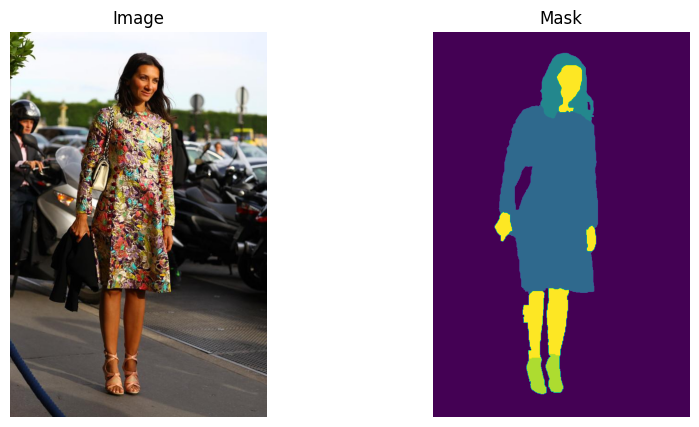

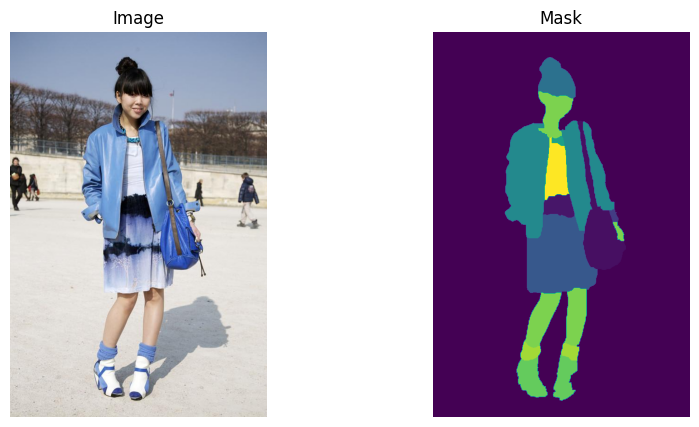

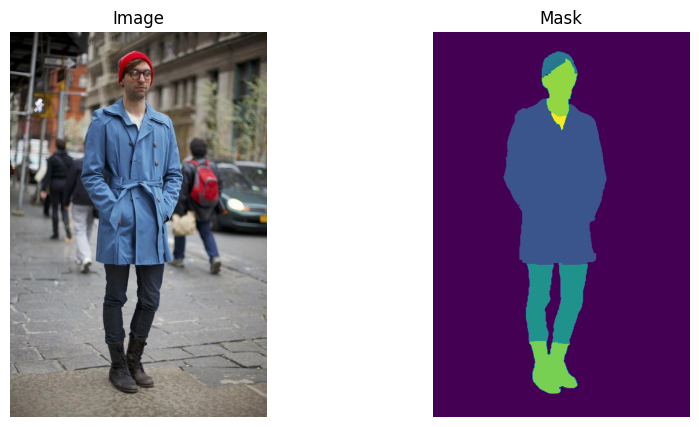

In [183]:
import random

random_indices = random.sample(range(len(dataset)), 3)

for idx in random_indices:
    image, mask = dataset[idx]
    show_image_with_mask(image, mask)


In [180]:
for idx in range(7):
    _, mask = dataset[idx]  # Получаем маску для конкретного индекса

    unique_classes = torch.unique(mask)  # Получаем уникальные значения на маске
    num_classes = len(unique_classes)  # Подсчитываем количество уникальных классов на маске

    print(f"Маска {idx + 1}: Количество классов - {num_classes}")


Маска 1: Количество классов - 9
Маска 2: Количество классов - 7
Маска 3: Количество классов - 14
Маска 4: Количество классов - 10
Маска 5: Количество классов - 9
Маска 6: Количество классов - 9
Маска 7: Количество классов - 7


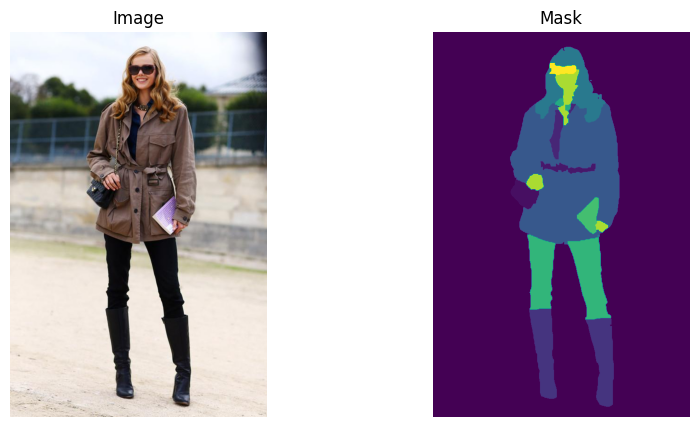

In [186]:
image, mask = dataset[2]
show_image_with_mask(image, mask)


<p class="task" id="3"></p>

3\. Реализуйте архитектуру U-Net. Реализуйте модель таким образом, чтобы на выходе для каждого изображения получался тензор размера `n_classes x h x w`, где `n_classes` - количество уникальных значений в масках, а `h` и `w` - размер исходного изображения. Возьмите один пример из набора данных и пропустите его через сеть. Выведите форму полученного результата на экран.

- [ ] Проверено на семинаре

In [15]:
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

In [16]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
	def forward(self, x):
		return self.conv2(self.relu(self.conv1(x)))

In [17]:
class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()

		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):

		blockOutputs = []

		for block in self.encBlocks:
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)

		return blockOutputs

In [18]:
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		for i in range(len(self.channels) - 1):
			x = self.upconvs[i](x)
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		return x
	def crop(self, encFeatures, x):

		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		return encFeatures

In [202]:
class UNet(nn.Module):
    def __init__(self, encChannels=(3, 16, 32, 64),
        decChannels=(64, 32, 16),
        nbClasses=59, retainDim=True,
        outSize=(128,  128)):
        super().__init__()

        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)

        self.head = nn.Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize

    def forward(self, x):

            encFeatures = self.encoder(x)

            decFeatures = self.decoder(encFeatures[::-1][0],
                encFeatures[::-1][1:])

            map = self.head(decFeatures)

            if self.retainDim:
                map = F.interpolate(map, self.outSize)

            return map

In [224]:
image_transform = transforms.Compose([
    transforms.Resize((128, 128))
])

mask_transform = transforms.Compose([
    transforms.Resize((128, 128))
])


dataset = ClothesSegmentationDataset(
    '/content/png_images/IMAGES/',
    '/content/png_masks/MASKS/',
    transform_images=image_transform,
    transform_masks=mask_transform
)

In [225]:
dataset[0][0].shape

torch.Size([3, 128, 128])

In [226]:
unet = UNet()

In [227]:
unet(dataset[0][0].unsqueeze(0)).shape

torch.Size([1, 59, 128, 128])

<p class="task" id="4"></p>

4\.  Разбейте набор данных на обучающее и валидационное множество. Обучите модель U-Net для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Обратите внимание, что выборка является несбалансированной. При расчете функции потерь примените любую известную вам технику для работы с несбалансированными выборками.

При создании датасета допускается использовать преобразования, уменьшающие размер изображений (для ускорения процесса обучения).

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре

In [235]:
from sklearn.utils.class_weight import compute_class_weight

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
from PIL import Image
import os
import torch.optim as optim
import torch.nn.functional as F



In [237]:
all_masks = []
for idx in range(len(dataset)):
    _, mask = dataset[idx]
    all_masks.append(mask)

In [238]:
all_masks = torch.cat(all_masks, dim=0)

In [239]:
unique_classes = torch.unique(all_masks)
unique_classes

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58], dtype=torch.int32)

In [241]:
num_classes = len(unique_classes)

In [242]:
class_weights = []
total_pixels = all_masks.numel()

for cls in unique_classes:
    class_count = torch.sum(all_masks == cls)
    class_weight = total_pixels / (class_count * num_classes)
    class_weights.append(class_weight.item())

In [248]:
class_weights = torch.tensor(class_weights)

In [249]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)


In [250]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [251]:

device

device(type='cuda')

In [252]:
model = UNet()
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model.to(device)


In [215]:
from tqdm import tqdm

In [254]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, masks.squeeze().long())

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)

            loss = criterion(outputs, masks.squeeze().long())

            val_loss += loss.item() * images.size(0)

    val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch [{epoch + 1}/{num_epochs}] -> Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")



100%|██████████| 400/400 [00:31<00:00, 12.58it/s]


Epoch [1/10] -> Train Loss: 4.0826, Val Loss: 4.0755


100%|██████████| 400/400 [00:29<00:00, 13.66it/s]


Epoch [2/10] -> Train Loss: 4.0698, Val Loss: 4.0698


100%|██████████| 400/400 [00:29<00:00, 13.61it/s]


Epoch [3/10] -> Train Loss: 4.0665, Val Loss: 4.0677


100%|██████████| 400/400 [00:29<00:00, 13.65it/s]


Epoch [4/10] -> Train Loss: 4.0647, Val Loss: 4.0664


100%|██████████| 400/400 [00:29<00:00, 13.42it/s]


Epoch [5/10] -> Train Loss: 4.0637, Val Loss: 4.0636


100%|██████████| 400/400 [00:29<00:00, 13.51it/s]


Epoch [6/10] -> Train Loss: 4.0587, Val Loss: 4.0565


100%|██████████| 400/400 [00:31<00:00, 12.89it/s]


Epoch [7/10] -> Train Loss: 4.0567, Val Loss: 4.0602


100%|██████████| 400/400 [00:33<00:00, 12.04it/s]


Epoch [8/10] -> Train Loss: 4.0590, Val Loss: 4.0635


100%|██████████| 400/400 [00:34<00:00, 11.62it/s]


Epoch [9/10] -> Train Loss: 4.0587, Val Loss: 4.0580


100%|██████████| 400/400 [00:32<00:00, 12.18it/s]


Epoch [10/10] -> Train Loss: 4.0498, Val Loss: 4.0495


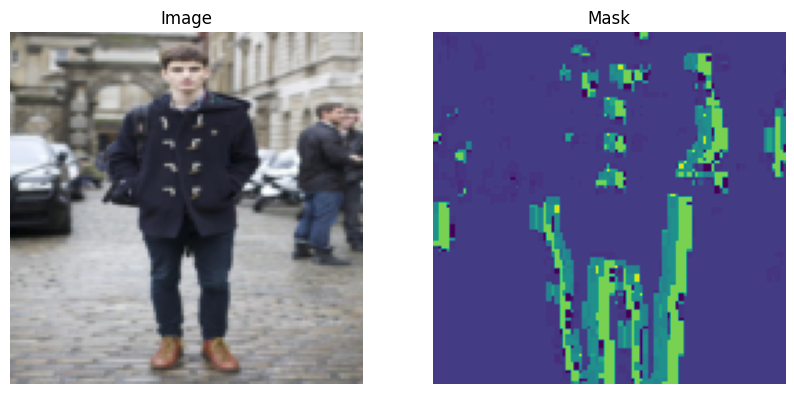

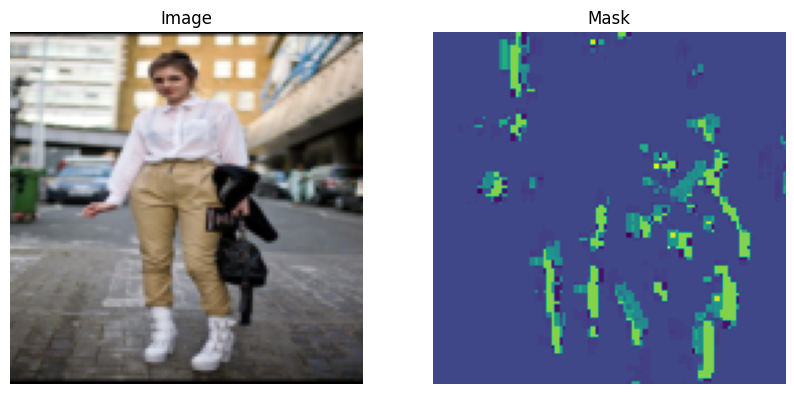

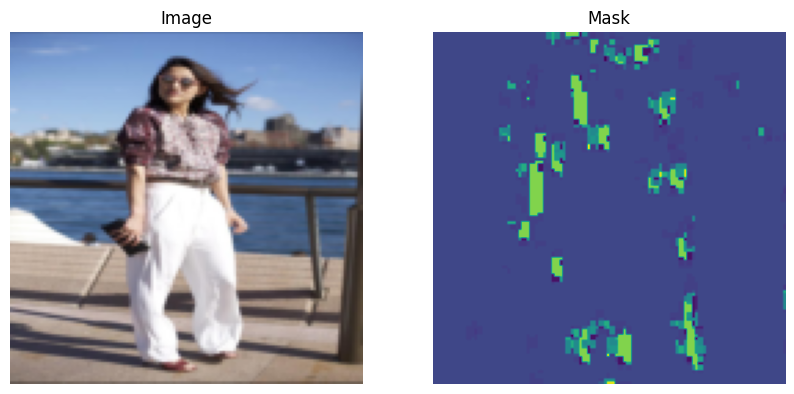

In [256]:
model.eval()
num_images_to_show = 3

for i, (image, mask) in enumerate(val_loader):
    if i == num_images_to_show:
        break

    image, mask = image.to(device), mask.to(device)
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)

    show_image_with_mask(image[0].cpu(), predicted[0].cpu())

<p class="task" id="5"></p>

5\.  Обучите модуль `SegformerForSemanticSegmentation` из пакета `transformers` для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Для оптимизации используйте значение функции потерь, которое возвращает вам модель.

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре

In [257]:
import pandas as pd
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import cached_download, hf_hub_url

In [258]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)


In [260]:
labels = pd.read_csv('labels.csv')
labels['label_list'] = labels['label_list'].astype(str)

In [261]:
label2id = dict(labels.values)
id2label = {v: k for k, v in label2id.items()}


In [262]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=59,
                                                         id2label=id2label,
                                                         label2id=label2id,)

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.2.proj.weight', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.classifier.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.classifier.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.1.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
pip install datasets

In [265]:
from datasets import load_metric

metric = load_metric("mean_iou")

<ipython-input-265-7fa4e6e26caa>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("mean_iou")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for mean_iou contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/mean_iou/mean_iou.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [266]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

In [ ]:
# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


In [272]:
model.train()
for epoch in range(4):
    print("Epoch:", epoch)
    for idx, batch in enumerate(tqdm(train_loader)):

        images, masks = batch[0], batch[1]


        images = images.to(device).float().cuda()
        masks = masks.squeeze(1).to(device).long().cuda()


        optimizer.zero_grad()


        outputs = model(pixel_values=images, labels=masks)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)


            metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=masks.detach().cpu().numpy())


        if idx % 500 == 0:
            metrics = metric._compute(references=masks.cpu(),
                                      predictions=predicted.cpu(),
                                      num_labels=len(id2label),
                                      ignore_index=255,
                                      reduce_labels=False,
            )

            print("Loss:", loss.item())
            print("Mean_iou:", metrics["mean_iou"])
            print("Mean accuracy:", metrics["mean_accuracy"])



Epoch: 0


  0%|          | 0/400 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:258: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 4.035855293273926
Mean_iou: 0.0016748557648334835
Mean accuracy: 0.015115872920007606
Epoch: 1


  0%|          | 0/400 [00:00<?, ?it/s]

Loss: 1.1282477378845215
Mean_iou: 0.029522995368540243
Mean accuracy: 0.04428198729195373
Epoch: 2


  0%|          | 0/400 [00:00<?, ?it/s]

Loss: 0.8284170627593994
Mean_iou: 0.05573033740159322
Mean accuracy: 0.07470090562295835
Epoch: 3


  0%|          | 0/400 [00:00<?, ?it/s]

Loss: 0.7939128875732422
Mean_iou: 0.046482334382205046
Mean accuracy: 0.0804498005658186


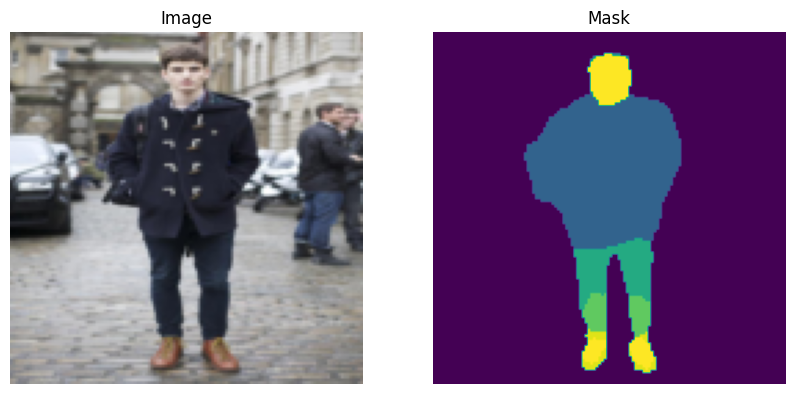

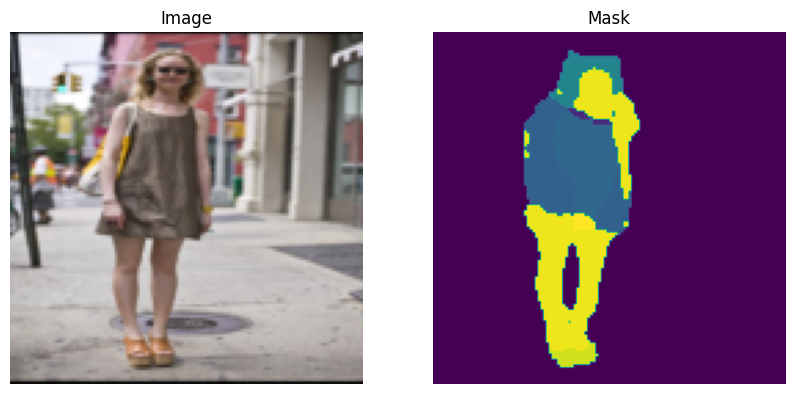

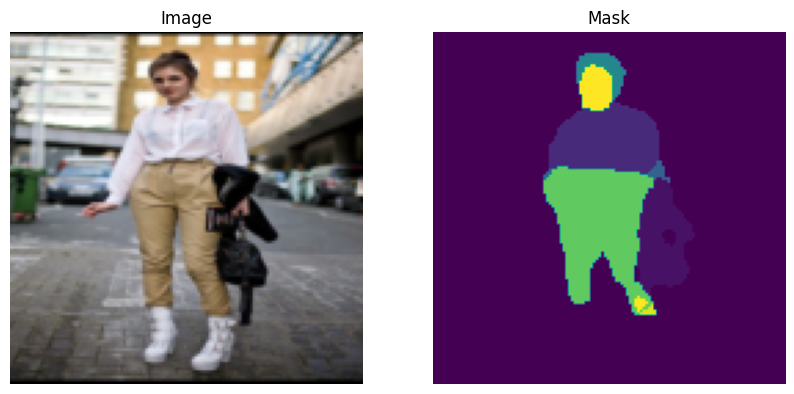

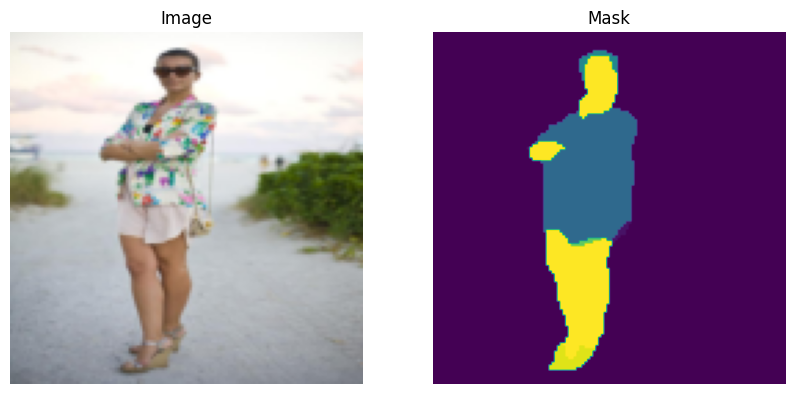

In [280]:
model.eval()

num_images_to_predict = 3
counter = 0

for idx, batch in enumerate(val_loader):
    if counter >= num_images_to_predict:
        break

    images, masks = batch[0], batch[1]
    images = images.to(device).float().cuda()

    with torch.no_grad():
        outputs = model(pixel_values=images)
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=images.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

    for i in range(len(images)):
        show_image_with_mask(images[i], predicted[i])
        counter += 1


## Обратная связь
- [ ] Хочу получить обратную связь по решению